# use Titus code to make barplots from the branchwater output
- (Sorry for being too slow on the manysearch)


In [63]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2025-workflow-core99/'

# parquet files from branchwater
BASE_OUTPUTS=BASE+'/outputs.branchwater'

In [64]:
import polars as pl
import numpy as np
import sklearn.tree
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [65]:
dirpath = BASE_OUTPUTS+'/*.parquet'

bw_df = pl.scan_parquet(dirpath).collect()
bw_df = bw_df.with_columns(pl.col("query_name").alias("species"),
                           pl.col("match_name").alias("acc"))
bw_df = bw_df.select(["species", "acc", "containment", "intersect_hashes"])

# mimic the Web site search threshold of 0.1
bw_df = bw_df.filter(pl.col("containment") >= .1)


In [66]:
# get metadata, only compare WGS
metadata_df = (
    pl.scan_parquet("/group/ctbrowngrp5/sra-metagenomes/20241128-metadata.parquet")
    .filter(pl.col("acc") != "NP")
    .filter(pl.col("assay_type") == "WGS")
    .select(["acc", "organism"]) 
    .collect()
)

In [ ]:
bw_df = bw_df.join(metadata_df, on="acc", how="left")

species,acc,containment,intersect_hashes,organism
str,str,f64,i64,str
"""s__Bariatricus sp004560705""","""SRR9866666""",0.689906,15002,"""Lawsonia intracellularis"""
"""s__Bariatricus sp004560705""","""SRR8960383""",0.681168,14812,"""pig gut metagenome"""
"""s__Bariatricus sp004560705""","""SRR17241623""",0.677121,14724,"""pig gut metagenome"""
"""s__Bariatricus sp004560705""","""ERR2241669""",0.677029,14722,"""metagenome"""
"""s__Bariatricus sp004560705""","""SRR11185229""",0.676707,14715,"""pig gut metagenome"""
…,…,…,…,…
"""s__UBA2868 sp004552595""","""SRR11183402""",0.100044,2263,"""pig gut metagenome"""
"""s__UBA2868 sp004552595""","""SRR20591093""",0.100044,2263,"""pig gut metagenome"""
"""s__UBA2868 sp004552595""","""SRR11125061""",0.1,2262,"""pig gut metagenome"""


In [68]:
# remove shitty entries with shitty metatada
# What is so difficult about adding an ORGANISM TO THIS???? WHO DOES THIS. "metagenome" is NOT INFORMATIVE 
def remove_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null"
    ]
    return df.filter(~pl.col("organism").is_in(bad_values))


In [69]:
# group by organism and count number of bacteria per SRA 
def pivot_count(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .group_by(["organism", "count"])
        .len()  # count occurrences
        .pivot(
            values="len",
            index="organism",
            columns="count"
        )
        .fill_null(0)  # optional: fill missing with 0
    )

685442

In [71]:
# remove unnanotated metags
df = remove_unnannotated(bw_df)
# count number of orgs in each mG
counts_df = (
    df
    .group_by(["acc", "organism"])
    .len()
    .rename({"len": "count"})
)

In [121]:
df

species,acc,containment,intersect_hashes,organism
str,str,f64,i64,str
"""s__Bariatricus sp004560705""","""SRR9866666""",0.689906,15002,"""Lawsonia intracellularis"""
"""s__Bariatricus sp004560705""","""SRR8960383""",0.681168,14812,"""pig gut metagenome"""
"""s__Bariatricus sp004560705""","""SRR17241623""",0.677121,14724,"""pig gut metagenome"""
"""s__Bariatricus sp004560705""","""SRR11185229""",0.676707,14715,"""pig gut metagenome"""
"""s__Bariatricus sp004560705""","""SRR17241692""",0.672522,14624,"""pig gut metagenome"""
…,…,…,…,…
"""s__UBA2868 sp004552595""","""SRR11126455""",0.100044,2263,"""pig gut metagenome"""
"""s__UBA2868 sp004552595""","""SRR11183402""",0.100044,2263,"""pig gut metagenome"""
"""s__UBA2868 sp004552595""","""SRR20591093""",0.100044,2263,"""pig gut metagenome"""


In [73]:
dfp = pivot_count(counts_df)
dfp

/tmp/ipykernel_10971/1745074137.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


organism,2,3,1,4,5,9,6,12,13,7,10,8,11,16,14,15
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""Ruminococcaceae bacterium D16""",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""canine metagenome""",36,4,105,0,0,0,0,0,0,0,0,0,0,0,0,0
"""urban metagenome""",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"""mixed sample""",13,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0
"""insect metagenome""",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""mollusc metagenome""",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"""Coprococcus sp. ART55_1""",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""Cervus nippon""",0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
# save then load as pandas bc dont want to rewrite all functions
dfp.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")


In [75]:
dfp =pd.read_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")
dfp

,organism,2,3,1,4,5,9,6,12,13,7,10,8,11,16,14,15
0,Ruminococcaceae bacterium D16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,canine metagenome,36,4,105,0,0,0,0,0,0,0,0,0,0,0,0,0
2,urban metagenome,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,mixed sample,13,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0
4,insect metagenome,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,mollusc metagenome,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
240,Coprococcus sp. ART55_1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241,Cervus nippon,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
242,Duncaniella dubosii,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:

category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  


In [112]:
def group_for_plot(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

In [77]:
# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/other': '#2a9d8f',
    'pig-associated': '#e9c46a'
    }

In [127]:
# plot the numbers
def plot_cat(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        color=[colors[c] for c in df_abs.index]
    )
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', loc='upper right')
    plt.tight_layout()


# plot relative percentages
def plot_cat_percent(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
    ax = df_norm.T.plot(
        kind='bar',
        stacked=True,
        figsize=(6,6),
        color=[colors[c] for c in df_norm.index]
    )
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()


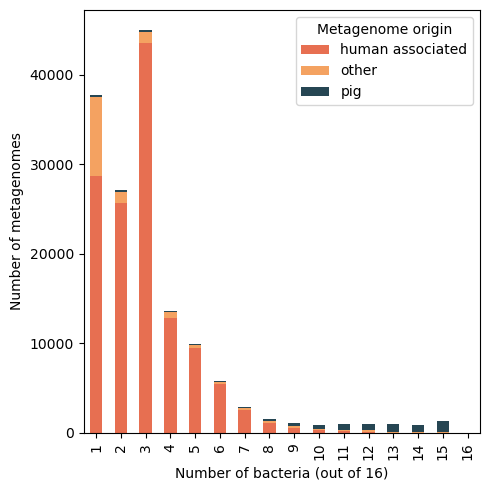

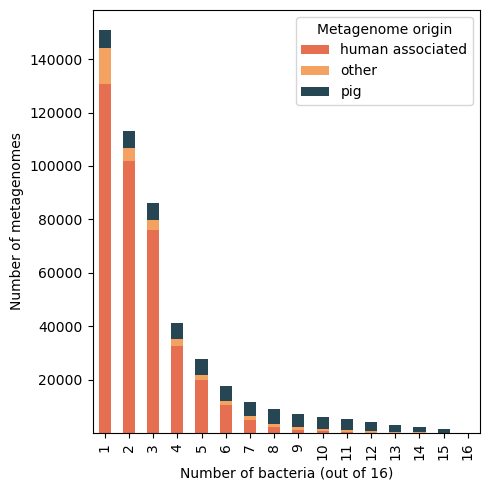

In [123]:
# make chart with absolute numbers and not percentages
plot_cat(df_ind)
plot_cat(df_cm)

In [125]:
df_ind

,broad_cat,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,human associated,28736,25690,43528,12825,9436,5469,2579,1113,574,276,232,82,36,3,1,0
1,other,8752,1195,1258,632,387,188,193,172,159,133,124,196,112,84,102,21
2,pig,202,198,177,113,154,173,175,314,393,510,611,750,813,755,1220,12


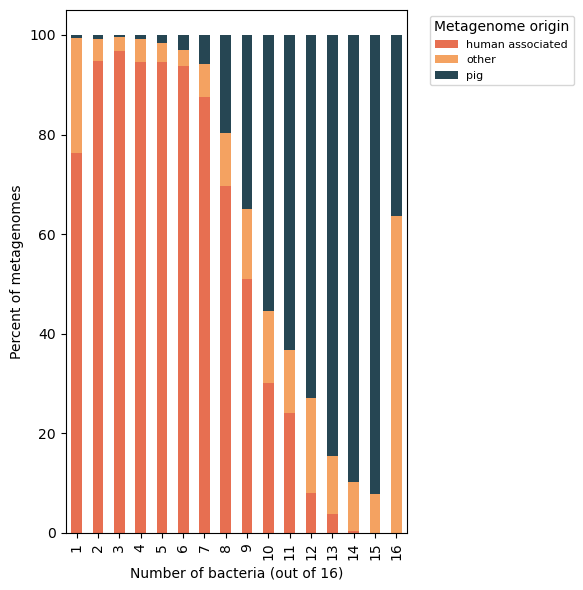

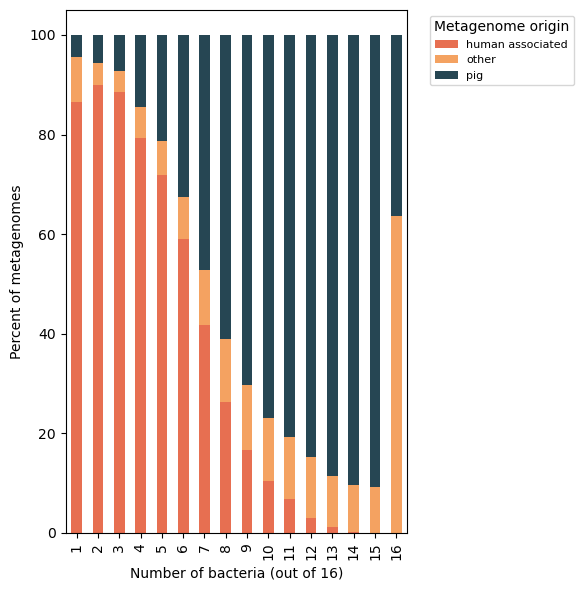

In [128]:
# Plot in percentages 
# this is skewed. at 16 spp there are only 33 entries
plot_cat_percent(df_ind)
plot_cat_percent(df_cm)